# [단변량 시계열 데이터 예측](https://codetorial.net/tensorflow/time_series_forecasting/forecast_a_univariate_time_series.html)

## [날씨 데이터셋](https://codetorial.net/tensorflow/time_series_forecasting/weather_dataset.html)
- 예측에 사용할 시계열 데이터로 독일의 Max Planck Institute for Biogeochemistry에서 관측한 날씨 데이터셋을 사용합니다.
- 이 날씨 데이터셋은 2003년 이후 10분 간격으로 관측된 온도, 대기압, 습도와 같은 14종류의 다양한 관측치를 포함하고 있습니다.
- 편의를 위해 2009년부터 2016년 사이의 데이터만 사용합니다.

In [1]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

13568290/13568290 [==============================] - 1s 0us/step


In [2]:
zip_path

'/Users/gyoungwon-cho/.keras/datasets/jena_climate_2009_2016.csv.zip'

In [3]:
csv_path

'/Users/gyoungwon-cho/.keras/datasets/jena_climate_2009_2016.csv'

In [5]:
df = pd.read_csv(csv_path)
print(df.columns)
df.head()

Index(['Date Time', 'p (mbar)', 'T (degC)', 'Tpot (K)', 'Tdew (degC)',
       'rh (%)', 'VPmax (mbar)', 'VPact (mbar)', 'VPdef (mbar)', 'sh (g/kg)',
       'H2OC (mmol/mol)', 'rho (g/m**3)', 'wv (m/s)', 'max. wv (m/s)',
       'wd (deg)'],
      dtype='object')


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


### 시계열 데이터셋 생성
- history_size는 과거 데이터의 크기를 의미합니다.
- target_size는 모델이 얼마 동안의 미래를 예측할지를 의미합니다.

In [6]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

- 이제부터 데이터셋의 앞에서부터 300,000개 행의 데이터를 훈련에 사용하고, 이후의 데이터들을 검증 (validation)에 사용합니다.
- 300,000개의 데이터는 약 2,083일 정도의 데이터입니다.
- 재현성을 보장하기 위해 시드를 설정합니다.

In [10]:
TRAIN_SPLIT = 300000
tf.random.set_seed(13)

### 온도 데이터 추출

In [13]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

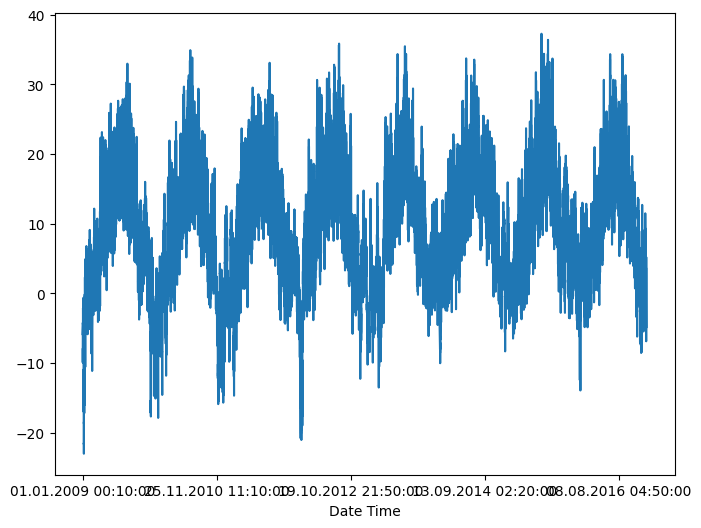

In [14]:
uni_data.plot(subplots=True)
plt.show()

### 표준화(Standardization)

In [17]:
uni_data = uni_data.values
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data - uni_train_mean) / uni_train_std  # Standardization

uni_data

array([-1.99766294, -2.04281897, -2.05439744, ..., -1.43494935,
       -1.55883897, -1.62715193])

## 첫번재 예측
- 이제 단변량 모델을 위한 데이터를 생성합니다.
- 우선 20개의 온도 관측치를 입력하면 다음 시간 스텝의 온도를 예측하도록 합니다.

In [18]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                        univariate_past_history,
                                        univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                    univariate_past_history,
                                    univariate_future_target)

print('Single window of past history')
print(x_train_uni[0])
print('\n Target temperature to predict')
print(y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


In [19]:
def create_time_steps(length):
    return list(range(-length, 0))


def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.axis('auto')
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

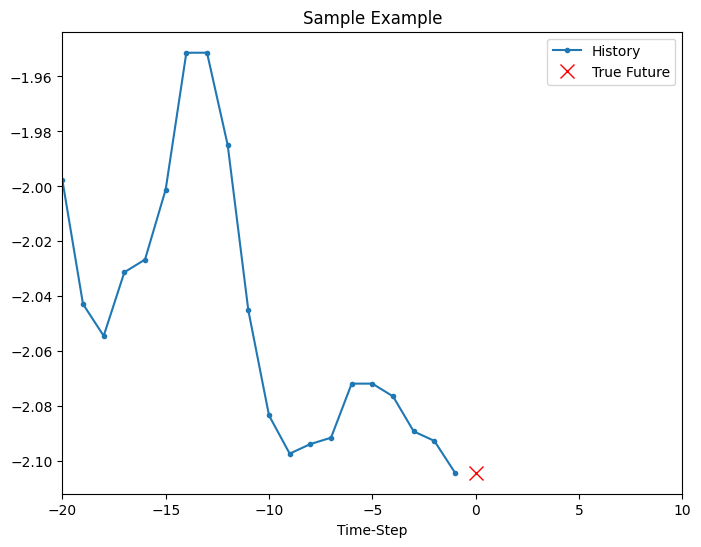

In [20]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example').show()

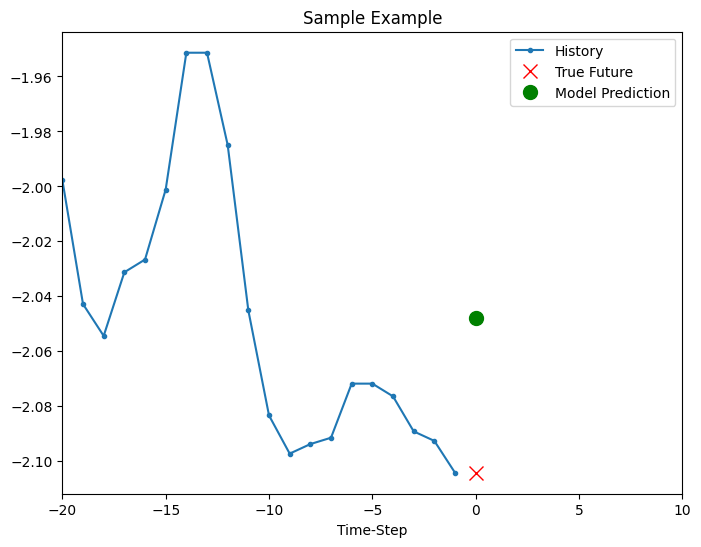

In [21]:
def baseline(history):
    return np.mean(history)


show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0, 'Sample Example').show()

## [LSTM](https://codetorial.net/tensorflow/time_series_forecasting/recurrent_neural_network.html)

- `cache()`는 데이터셋을 캐시, 즉 메모리 또는 파일에 보관합니다. 따라서 두번째 이터레이션부터는 캐시된 데이터를 사용합니다.
- `shuffle()`는 데이터셋을 임의로 섞어줍니다. BUFFER_SIZE개로 이루어진 버퍼로부터 임의로 샘플을 뽑고, 뽑은 샘플은 다른 샘플로 대체합니다. 완벽한 셔플을 위해서 전체 데이터셋의 크기에 비해 크거나 같은 버퍼 크기가 요구됩니다.
- `batch()`는 데이터셋의 항목들을 하나의 배치로 묶어줍니다.

## Dataset

In [23]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

In [24]:
train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

## Model

In [25]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

## Train

In [26]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                    steps_per_epoch=EVALUATION_INTERVAL,
                    validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 2s 5ms/step - loss: 0.1793 - val_loss: 0.0527
Epoch 2/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0541 - val_loss: 0.0261
Epoch 3/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0339 - val_loss: 0.0212
Epoch 4/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0307 - val_loss: 0.0197
Epoch 5/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0228 - val_loss: 0.0187
Epoch 6/10
200/200 [==============================] - 1s 4ms/step - loss: 0.0251 - val_loss: 0.0184
Epoch 7/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0233 - val_loss: 0.0174
Epoch 8/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0226 - val_loss: 0.0172
Epoch 9/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0222 - val_loss: 0.0162
Epoch 10/10
200/200 [==============================] - 1s 3ms/step - loss: 0.0203 - val_loss: 0.0158

## Predict

8/8 [==============================] - 0s 1ms/step


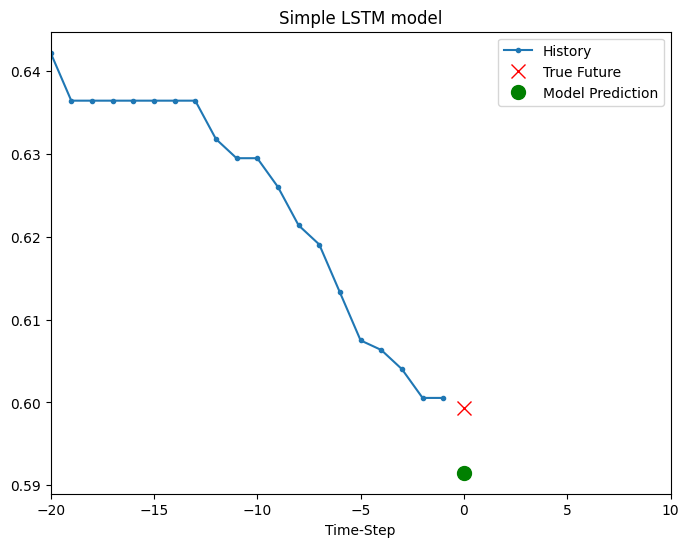

8/8 [==============================] - 0s 1ms/step


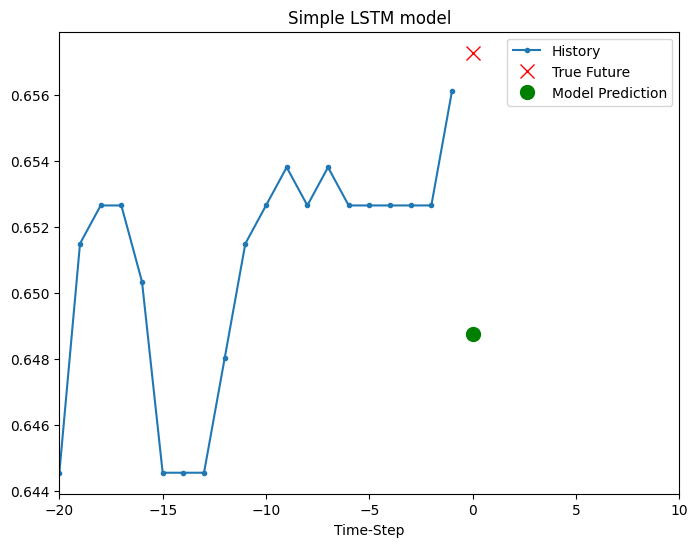

8/8 [==============================] - 0s 4ms/step


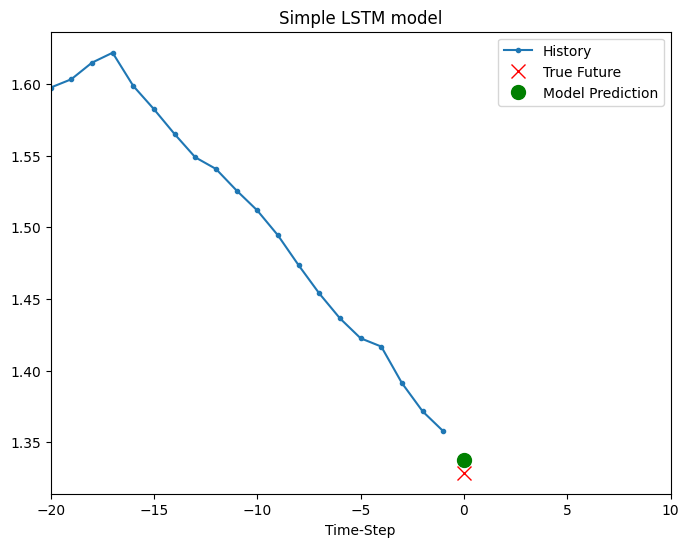

In [27]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

# [다변량 시계열 데이터 예측](https://codetorial.net/tensorflow/time_series_forecasting/forecast_a_multivariate_time_series.html)
예제에서는 문제를 간단하게 하게 위해 14개 중 온도 (air temperature), 기압 (atmospheric pressure), 공기밀도 (air density) 데이터 세가지 속성을 다룹니다.

In [28]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']
features = df[features_considered]
features.index = df['Date Time']

features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


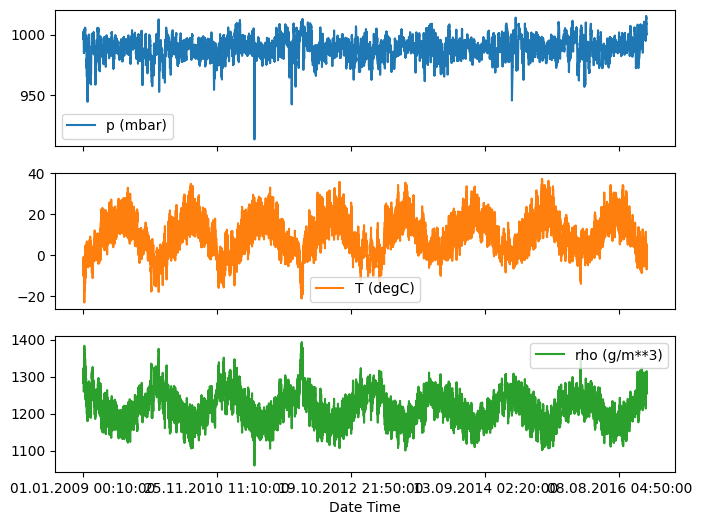

In [29]:
features.plot(subplots=True)
plt.show()

## 표준화(Standardization)

In [30]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

print(dataset)

[[ 0.95547359 -1.99766294  2.2350791 ]
 [ 0.96154485 -2.04281897  2.28524007]
 [ 0.95668784 -2.05439744  2.29600633]
 ...
 [ 1.35617678 -1.43494935  1.76136375]
 [ 1.35496252 -1.55883897  1.88786728]
 [ 1.35617678 -1.62715193  1.95686921]]


## 한 스텝 예측(Single step model)
이제 신경망 모델은 주어진 과거의 자료로부터 하나의 포인트를 예측하는 것을 학습합니다.

In [32]:
def multivariate_data(dataset, target, start_index, end_index, history_size, target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i - history_size, i, step)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i + target_size])
        else:
            labels.append(target[i:i + target_size])
    return np.array(data), np.array(labels)

In [33]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0, TRAIN_SPLIT, past_history,
                                                future_target, STEP, single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1], TRAIN_SPLIT, None, past_history,
                                            future_target, STEP, single_step=True)

print('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


### Dataset

In [34]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

### Model

In [35]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32, input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))
single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

### Train

In [36]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)


8/8 [==============================] - 0s 4ms/step
(256, 1)
Epoch 1/10
200/200 [==============================] - 11s 50ms/step - loss: 0.3137 - val_loss: 0.2592
Epoch 2/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2658 - val_loss: 0.2445
Epoch 3/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2638 - val_loss: 0.2420
Epoch 4/10
200/200 [==============================] - 9s 47ms/step - loss: 0.2566 - val_loss: 0.2331
Epoch 5/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2261 - val_loss: 0.2355
Epoch 6/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2406 - val_loss: 0.2523
Epoch 7/10
200/200 [==============================] - 10s 48ms/step - loss: 0.2418 - val_loss: 0.2533
Epoch 8/10
200/200 [==============================] - 10s 49ms/step - loss: 0.2418 - val_loss: 0.2479
Epoch 9/10
200/200 [==============================] - 9s 47ms/step - loss: 0.2430 - val_loss: 0.2450
Epoch 10/10
200/200 [===

### Predict

In [37]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

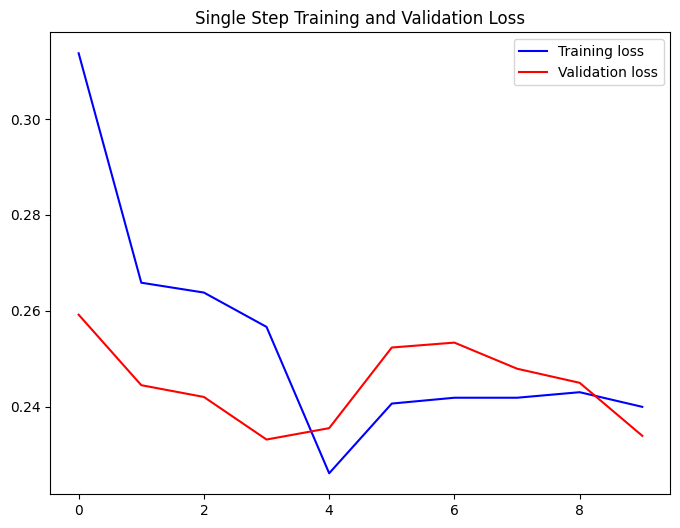

In [38]:
plot_train_history(single_step_history,
                'Single Step Training and Validation Loss')

8/8 [==============================] - 0s 4ms/step


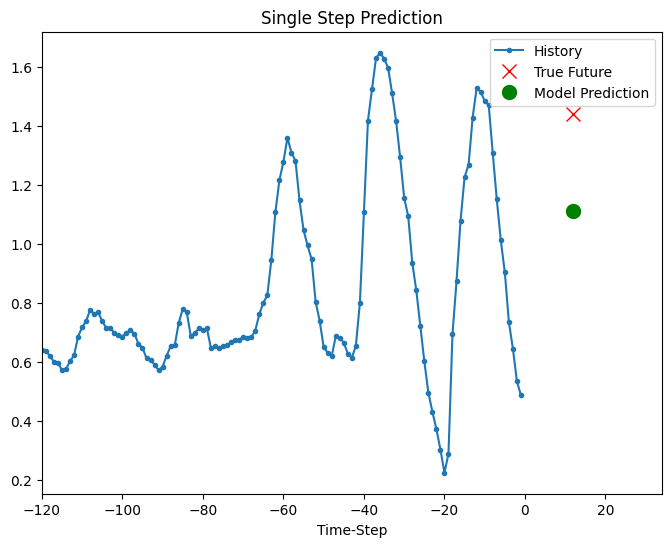

8/8 [==============================] - 0s 6ms/step


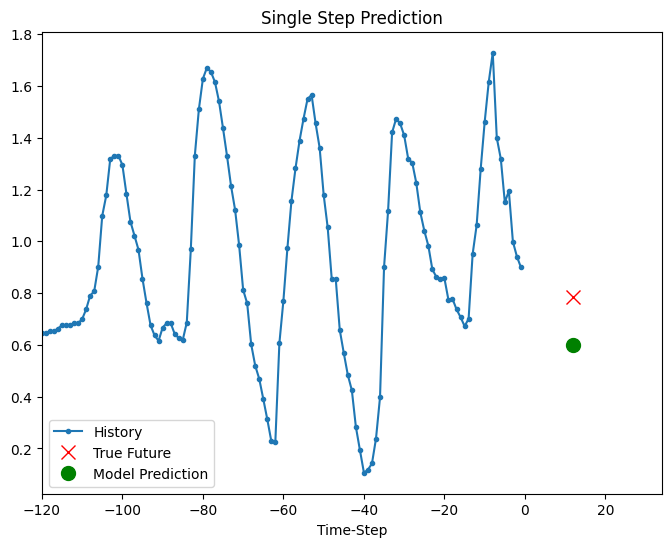

8/8 [==============================] - 0s 4ms/step


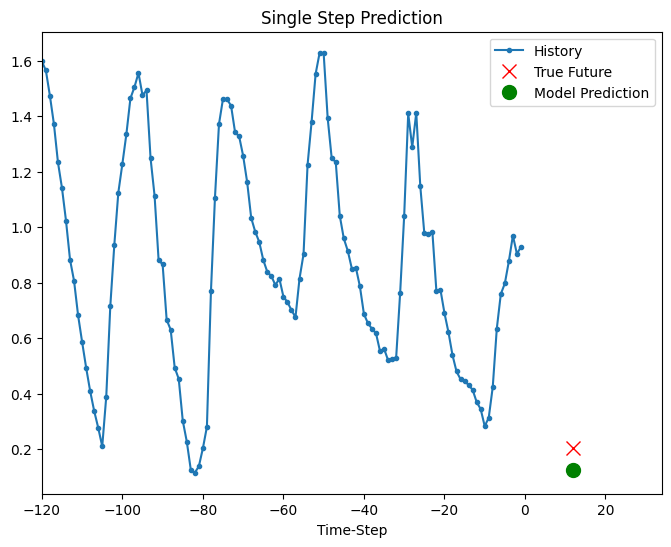

In [39]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                    'Single Step Prediction')
    plot.show()